In [ ]:
# =============================================================================
#                            Import Libraries
# =============================================================================
import tensorflow as tf                         # Core TensorFlow framework
import tensorflow_probability as tfp            # TensorFlow Probability extensions

import numpy as np                              # Numerical arrays
import random                                   # Random number utilities
from scipy.interpolate import UnivariateSpline, interp1d  # Spline interpolation
import matplotlib.pyplot as plt                 # Plotting
from matplotlib import rcParams                 # Matplotlib configuration

# =============================================================================
#                 TensorFlow Precision Configuration
# =============================================================================
# Use 64‑bit floats for better numerical accuracy in scientific computing
tf.keras.backend.set_floatx('float64')

# =============================================================================
#                         Problem Parameters
# =============================================================================
# Load physical property data from CSV (skip header row)
loaded_data = np.loadtxt("properties_data.csv", delimiter=",", skiprows=1)

# Extract columns: parameter, density ρ(T), heat capacity c(T), conductivity k(T)
Temp_param = loaded_data[:, 0]
func_rho    = loaded_data[:, 1]
func_cp     = loaded_data[:, 2]
func_k      = loaded_data[:, 3]

# Load boundary-condition data (time vs. temperature)
loaded_data2 = np.loadtxt("data_boundary.csv", delimiter=",", skiprows=1)
time_bc      = loaded_data2[:, 0]
Temp_bc0     = loaded_data2[:, 1]

# Load experimental model data (time vs. experimental temperature)
loaded_data3   = np.loadtxt("data_model.csv", delimiter=",", skiprows=1)
time_experim   = loaded_data3[:, 0]
Temp_experim0  = loaded_data3[:, 1]

# =============================================================================
#                         Model Hyperparameters
# =============================================================================
NN       = 10     # neurons per hidden layer
NL       = 5      # number of hidden layers
N_points = 150    # collocation points for PDE training
N_test   = 20     # test points for evaluation
N_epoch  = 20000  # training epochs

# =============================================================================
#                   Time Discretization Parameters
# =============================================================================
Time     = 1                 # nondimensional final time
t_steps  = 1000              # number of time steps
delta_t  = Time / t_steps    # time-step size
time     = np.linspace(0, Time, t_steps + 1)  # array of time points

# =============================================================================
#                   Non‑dimensionalization Constants
# =============================================================================
L_ref    = 0.5715         # reference tank length (m)
L        = 1              # nondimensional length
T_ref    = 20             # reference temperature (°C)
time_ref = 21600 / 3      # reference time (s)

delta_x = L / N_points    # nondimensional spatial step

# Compute nondimensional thermal diffusivity α(T) and conductivity κ(T)
non_dim_alpha   = (L_ref**2 * func_rho * func_cp) / (time_ref * min(func_k))
non_dim_kappa   = func_k / min(func_k)

# Stability constant: worst‑case ratio for time‑step constraint
#worst_C = max(func_k) / (min(func_rho * func_cp))
worst_C = max(non_dim_kappa) / (min(non_dim_alpha))

# Print Courant‑type condition check
print('Delta_t es:           ', delta_t)
print('Delta_t debe ser ≤    ', delta_x**2 / (2 * worst_C))

# =============================================================================
#                        Boundary‑Condition Splines
# =============================================================================
# Create interpolating splines for BC and experimental data
spline_bc    = interp1d(time_bc / time_ref,    Temp_bc0 / T_ref)
spline_model = interp1d(time_experim / time_ref, Temp_experim0 / T_ref)

# Compute nondimensional BC and experimental temperature over time grid
Temp_bc       = (spline_bc(time) + spline_model(time)) / 2
Temp_experim  = spline_model(time)

# Uncomment for quick sanity checks:
# print(min(spline_bc(time)), min(Temp_bc), max(Temp_bc),
#       min(func_cp), max(func_cp))

# =============================================================================
#                    Custom TensorFlow Layer: Enforce BC
# =============================================================================
class cutoff(tf.keras.layers.Layer):
    """
    Custom layer that applies a spatial cutoff function to enforce
    boundary conditions across all time steps.
    """
    def __init__(self, L, BC, **kwargs):
        super(cutoff, self).__init__()
        self.L = L      # Domain length (nondimensional)
        self.BC = BC    # Precomputed boundary-condition values (array)

    def call(self, inputs):
        """
        inputs:
          x: tensor of spatial coordinates (shape: [batch_size, 1])
          u: tensor of raw NN outputs for each time step
             (shape: [batch_size, t_steps+1])
        returns:
          cut * u + BC, which ensures u(x=0) and u(x=L) match BC
        """
        x, u = inputs

        # Cutoff function zeroes out network output at x=0 and x=L
        cut = x * (x - self.L)      # shape: (batch_size, 1)
        cut = tf.reshape(cut, [-1, 1])

        # Apply cutoff to every time-step prediction, then add BC
        return cut * u + self.BC


# =============================================================================
#                 Neural Network Architecture Definition
# =============================================================================
# Input layer: spatial coordinate x (scalar)
X = tf.keras.layers.Input(shape=(1,))

# First hidden layer: NN neurons with tanh activation
L1 = tf.keras.layers.Dense(units=NN, activation='tanh')(X)

# Additional hidden layers: NL-2 layers, each with NN neurons
for _ in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation='tanh')(L1)

# Last dense layer: outputs t_steps+1 predictions (one per time step)
L_last = tf.keras.layers.Dense(
    units=t_steps + 1,
    activation='tanh',
    dtype='float64'   # ensure double precision consistency
)(L1)

# Apply custom cutoff layer: enforce BC across all time steps
L_out = cutoff(L, Temp_bc)([X, L_last])


# =============================================================================
#                      Model Assembly and Summary
# =============================================================================
# Build the model mapping spatial input X → solution U_model(X, t)
U_model = tf.keras.Model(inputs=X, outputs=L_out, name='U_model')

# Print model architecture details for verification
U_model.summary()





Delta_t es:  0.001
Delta_t debe ser:  0.002400971228003746


In [ ]:
# =============================================================================
#                         Custom Loss Layer Definition
# =============================================================================
class loss(tf.keras.layers.Layer):
    """
    Custom layer that computes:
      1) PDE residual loss via quadrature over random collocation points
      2) Relative squared error between model prediction at x=L/2 and exact data
    """
    def __init__(self, U_model, N_points, N_test, t_steps, delta_t, L,
                 T_model, non_dim_alpha, non_dim_kappa, T_exact, **kwargs):
        super(loss, self).__init__()
        
        # Reference to the trained model
        self.U_model      = U_model
        
        # Number of collocation points for PDE integration
        self.N_points     = N_points
        
        # Number of basis/test functions for variational formulation
        self.N_test       = N_test
        
        # Time‐stepping parameters
        self.t_steps      = t_steps
        self.dt           = delta_t
        
        # Spatial domain length (nondimensional)
        self.L            = L
        
        # Range of model‐mapped temperature values
        self.T_model_max  = max(T_model)
        self.T_model_min  = min(T_model)
        
        # Nondimensional thermal diffusivity and conductivity arrays
        self.alpha        = non_dim_alpha
        self.kappa        = non_dim_kappa
        
        # Exact solution data for error computation
        self.T_exact      = T_exact

    def call(self, input):
        """
        input: (unused) placeholder for compatibility with Keras API.
        Returns: tf.stack([loss_out, Error])
        """
        # ---------------------------------------------------------------------
        # 1) Sample random collocation points in [0, L] and include endpoints
        # ---------------------------------------------------------------------
        random_points = tf.random.uniform(
            shape=(self.N_points,), minval=0.0, maxval=self.L, dtype=tf.float64
        )
        extremes      = tf.concat([[0.0], random_points, [self.L]], axis=0)
        sorted_points = tf.sort(extremes)
        
        # Midpoints and interval sizes for quadrature
        S              = (sorted_points[:-1] + sorted_points[1:]) / 2
        interval_sizes = sorted_points[1:] - sorted_points[:-1]
        
        # Validation grid (unused in current loss, but available)
        npoints_valerror = self.N_points * 5
        Sval             = tf.experimental.numpy.linspace(
            0.0, self.L, num=npoints_valerror, dtype='float64'
        )
        
        # ---------------------------------------------------------------------
        # 2) Evaluate model and basis functions under GradientTape
        # ---------------------------------------------------------------------
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(S)
            
            # Model output u(x,t) on collocation points: shape (t_steps+1, N_points+2)
            ueval = tf.transpose(self.U_model(S))
            
            # Variational basis functions G_i(x) and their gradients H_i(x)
            G = tf.experimental.numpy.asarray([
                (self.L/(i*np.pi)) * (np.sqrt(2/self.L)) * tf.math.sin(i*np.pi*S/self.L)
                for i in range(1, self.N_test+1)
            ], dtype='float64')
            
            H = tf.experimental.numpy.asarray([
                (np.sqrt(2/self.L)) * tf.cos(i*np.pi*S/self.L)
                for i in range(1, self.N_test+1)
            ], dtype='float64')
            
            # Initialize accumulated loss
            loss_out = 0.0
            
            # -----------------------------------------------------------------
            # 3) Loop over time steps to build PDE residual via quadrature
            # -----------------------------------------------------------------
            for t in range(1, self.t_steps + 1):
                # Interpolate conductivity and diffusivity at previous step
                param1 = self.dt * tfp.math.interp_regular_1d_grid(
                    20.0 * ueval[t-1],
                    self.T_model_min, self.T_model_max,
                    self.kappa
                )
                param2 = 1.0 / tfp.math.interp_regular_1d_grid(
                    20.0 * ueval[t-1],
                    self.T_model_min, self.T_model_max,
                    self.alpha
                )
                
                # Source term integral at t=1 uses initial condition U0 = 1.0
                if t == 1:
                    U0 = tf.constant([1.0], dtype='float64')
                    param_rhs = tfp.math.interp_regular_1d_grid(
                        20.0 * U0, self.T_model_min, self.T_model_max, self.alpha
                    )
                    Integral_source = -U0 * param_rhs * tf.einsum(
                        'i,i,ki->k', interval_sizes, param2, G
                    )
                else:
                    # For later times, use ueval[t-2]
                    param_rhs = tfp.math.interp_regular_1d_grid(
                        20.0 * ueval[t-2],
                        self.T_model_min, self.T_model_max,
                        self.alpha
                    )
                    Integral_source = tf.einsum(
                        'i,i,i,i,ki->k',
                        interval_sizes, param_rhs, param2,
                        -ueval[t-2], G
                    )
                
                # Derivative ∂u/∂x at time t-1
                u_x_tn = t1.gradient(ueval[t-1], S)
                
                # Diffusion term integral
                Integral_Unn = tf.einsum(
                    'i,i,i,i,ki->k',
                    interval_sizes, param1, param2, u_x_tn, H
                )
                
                # Mass/identity term integral
                Integral_nueva = tf.einsum(
                    'i,i,ki->k',
                    interval_sizes, ueval[t-1], G
                )
                
                # Accumulate squared residual
                loss_out += tf.reduce_sum(
                    (Integral_nueva + Integral_Unn + Integral_source) ** 2
                )
        
        # Clean up persistent tape
        del t1
        
        # ---------------------------------------------------------------------
        # 4) Compute relative squared error at x = L/2 between model and exact
        # ---------------------------------------------------------------------
        pred_mid = tf.transpose(self.U_model(tf.constant([self.L/2])))  # shape: (t_steps+1, 1)
        err_vec  = pred_mid - self.T_exact.reshape(self.t_steps, 1)
        Error    = tf.reduce_sum(err_vec ** 2) / tf.reduce_sum(self.T_exact ** 2)
        
        # Return stacked [PDE_residual_loss, data_error]
        return tf.stack([loss_out, Error])
    
# =============================================================================
#                    Wrap Custom Loss as a Keras Model
# =============================================================================
def loss_model(U_model, N_points, N_test, t_steps, dt, L,
               Temp_param, non_dim_alpha, non_dim_kappa, Temp_experim):
    """
    Constructs a small Keras model whose output is the custom loss layer.
    This allows TensorFlow to call the loss during training.
    """
    # Input placeholder for spatial coordinate x (unused inside loss, but required)
    Xl = tf.keras.layers.Input(shape=(1,), dtype='float64')

    # Instantiate the custom loss layer, passing in all necessary parameters
    loss_layer = loss(
        U_model, N_points, N_test, t_steps, dt, L,
        Temp_param, non_dim_alpha, non_dim_kappa, Temp_experim
    )(Xl)

    # Build and return a model that maps Xl → [PDE_loss, data_error]
    return tf.keras.Model(inputs=Xl, outputs=loss_layer)


# =============================================================================
#                Loss Extraction Helper Functions
# =============================================================================
def loss_value(x, y):
    """
    Extract the primary PDE‐residual loss (first component) from the custom loss output.
    Called by model.compile(loss=loss_value).
    """
    return y[0]


def err_value(x, y):
    """
    Extract the relative data‐error (second component) from the custom loss output.
    Can be used as a custom metric.
    """
    return y[1]


# =============================================================================
#           Assemble, Compile, and Train the Full Model
# =============================================================================
# Create the Keras model that produces the loss given a dummy input
model_all = loss_model(
    U_model,
    N_points,
    N_test,
    t_steps + 1,    # note: match the number of time‐step outputs
    delta_t,
    L,
    Temp_param,
    non_dim_alpha,
    non_dim_kappa,
    Temp_experim
)

# Choose Adam optimizer with a moderate learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=10**-2.5)

# Compile: use loss_value as the loss function, and err_value as a monitored metric
model_all.compile(
    optimizer=optimizer,
    loss=loss_value,
    metrics=[err_value]
)

# Early stopping to prevent overtraining: monitor loss, restore best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=1e-10,
    patience=1000,
    verbose=1,
    restore_best_weights=True
)

# Dummy “training” call: inputs/targets are placeholders (not used in the custom loss)
history = model_all.fit(
    x=np.array([1.]),   # single dummy input
    y=np.array([1.]),   # single dummy target
    epochs=N_epoch,
    callbacks=[early_stopping]
)



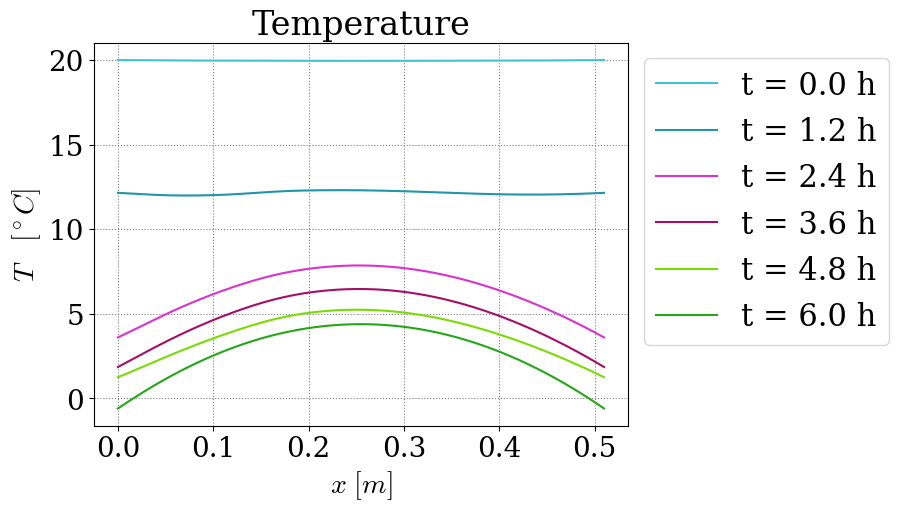

In [ ]:
# =============================================================================
#                    Matplotlib Global Style Configuration
# =============================================================================
# Set serif font for text and math, adjust base sizes for readability
rcParams['font.family']      = 'serif'
rcParams['font.size']        = 20
rcParams['legend.fontsize']  = 22
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize']   = 20

# =============================================================================
#                   Prepare Data for Visualization
# =============================================================================
# Create a uniform spatial grid over [0, L] matching the model’s output
xlist = tf.experimental.numpy.linspace(
    0.0, L, num=t_steps + 1, dtype='float32'
)

# Evaluate the trained model on the spatial grid:
# U_model(xlist) returns shape (batch, t_steps+1), transpose to (time, space)
uu = tf.transpose(U_model(xlist))

# =============================================================================
#                         Plot Neural Network Solution
# =============================================================================
fig, ax = plt.subplots()

# Plot solution snapshots at intervals of 200 time steps
for t in range(0, t_steps + 1, 200):
    # Random color for each curve
    c = np.random.rand(3)
    # Rescale: x by physical length (0.51 m), and temperature by T_ref=20
    ax.plot(
        xlist * 0.51,        # physical x coordinate [m]
        20 * uu[t, :],       # reconstructed temperature [°C]
        color=c,
        label=f"t = {6 * t * delta_t} h"
    )

# =============================================================================
#                           Finalize Plot Appearance
# =============================================================================
# Add grid lines for major ticks
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Tight layout so labels and legend fit without overlap
plt.tight_layout()

# Axis labels and title
plt.title('Temperature')
plt.xlabel(r'$x \; [\mathrm{m}]$')
plt.ylabel(r'$T \; [^\circ\mathrm{C}]$')

# Legend positioned outside plot area for clarity
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# =============================================================================
#                            Save and Show Plot
# =============================================================================
# Export as high-quality PDF
plt.savefig("plot_sol_Cafe.pdf", format="pdf", bbox_inches="tight")

# Display on screen
plt.show()


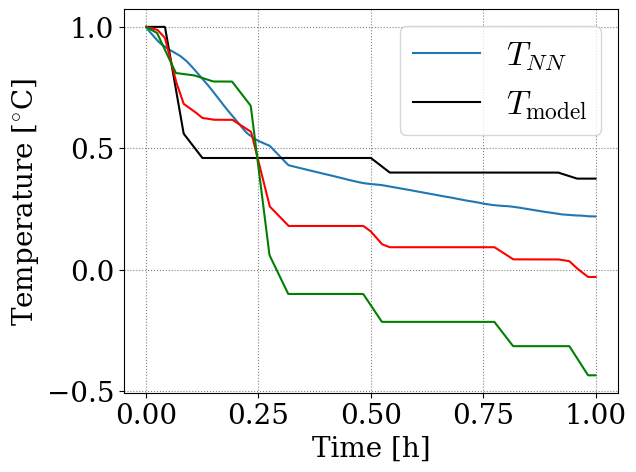

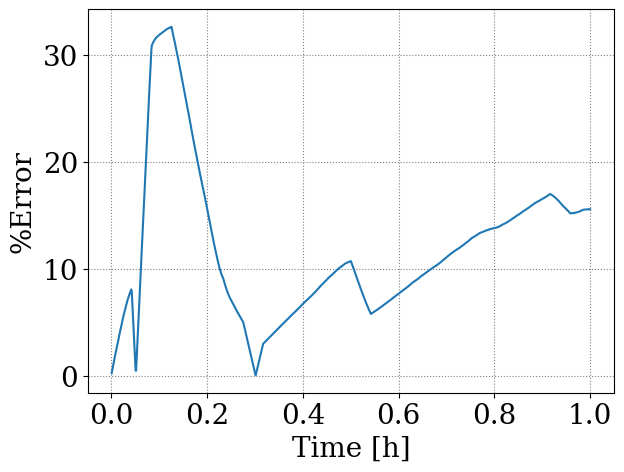

In [ ]:
# =============================================================================
#                  Time Grid for Temporal Visualization
# =============================================================================
# Create a uniform time vector from first time step to final time
time = tf.experimental.numpy.linspace(
    delta_t,         # start at first time increment
    Time,            # end at nondimensional final time
    num=t_steps + 1, # include all steps
    dtype='float32'
)

# =============================================================================
#             Evaluate Neural Network at Mid‑Tank Position
# =============================================================================
# Predict temperature at x = L/2 over all time steps
uu = tf.transpose(U_model(tf.constant([L/2])))
# (Alternative: x=0) uu = tf.transpose(U_model(tf.constant([0.0])))

# =============================================================================
#                    Plot Temperature vs. Time
# =============================================================================
fig, ax = plt.subplots()

# NN prediction
ax.plot(time, uu,                label=r'$T_{NN}$')

# Experimental model data
ax.plot(time, Temp_experim, 'k', label=r'$T_{\mathrm{model}}$')

# Boundary-condition average
ax.plot(time, Temp_bc,    'r', label=r'$T_{BC}$')

# Raw interpolated BC spline
ax.plot(time, spline_bc(time), 'g', label=r'Spline$_{BC}$')

# Add grid lines for clarity
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Ensure layout fits labels and legend
plt.tight_layout()

# Axis labels
plt.xlabel(r'Time [h]')
plt.ylabel(r'Temperature [$^\circ$C]$')

# Legend with custom font size
ax.legend(fontsize=16)

# Save as PDF
plt.savefig("plot_sol_CafeTime.pdf", format="pdf", bbox_inches="tight")

# Display plot
plt.show()


# =============================================================================
#                      Plot Percentage Error vs. Time
# =============================================================================
fig, ax = plt.subplots()

# Compute and plot percentage error: |T_NN − T_model| / max(T_model) × 100
percent_error = np.abs(uu - Temp_experim.reshape(t_steps + 1, 1)) \
                / np.max(Temp_experim) * 100
ax.plot(time, percent_error)

# Grid, layout, labels
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.tight_layout()
plt.xlabel(r'Time [h]')
plt.ylabel(r'% Error')

# Save and show
plt.savefig("plot_err_CafeTime.pdf", format="pdf", bbox_inches="tight")
plt.show()


# =============================================================================
#                  Compute Overall Relative Squared Error
# =============================================================================
# Difference vector between prediction and experimental model
aa = tf.transpose(U_model(tf.constant([L/2]))) - Temp_experim.reshape(t_steps + 1, 1)

# Relative squared error metric
Error = tf.reduce_sum(aa**2) / tf.reduce_sum(Temp_experim**2)

# Print or log Error if desired
print("Relative squared error:", Error.numpy())


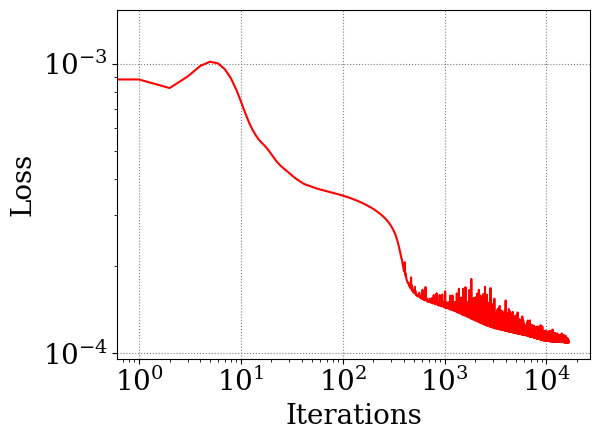

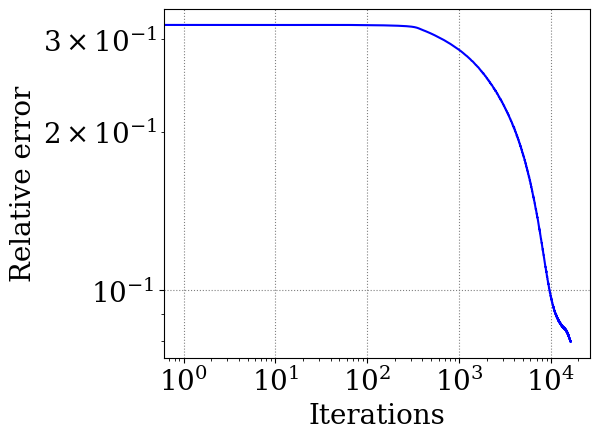

In [ ]:
# =============================================================================
#                  Prepare Loss and Error History Data
# =============================================================================
# Extract primary loss and relative error from training history
Loss_rel  = history.history['loss']
Error_rel = history.history['err_value']


# =============================================================================
#                      Plot Loss vs. Training Iterations
# =============================================================================
fig, ax = plt.subplots()

# Plot the loss curve (skip the first two points for clarity)
plt.plot(np.array(Loss_rel[2:]), color='r')

# Label axes
plt.ylabel(r'Loss')
plt.xlabel(r'Iterations')

# Use logarithmic scales to capture wide dynamic range
ax.set_xscale('log')
ax.set_yscale('log')

# Add grid lines for readability
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Tight layout so nothing is cut off
plt.tight_layout()

# Save as high‑quality PDF
plt.savefig("plot_loss_Cafe.pdf", format="pdf", bbox_inches="tight")

# Display the figure
plt.show()


# =============================================================================
#                   Plot Relative Error vs. Iterations
# =============================================================================
fig, ax = plt.subplots()

# Plot the relative error curve (skip the first two points)
plt.plot(np.array(Error_rel[2:]), color='b')

# Label axes
plt.ylabel(r'Relative error')
plt.xlabel(r'Iterations')

# Logarithmic scales for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Add grid lines
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Tight layout for neatness
plt.tight_layout()

# Save as PDF
plt.savefig("plot_Error_Cafe.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()
